<a href="https://colab.research.google.com/github/zw2497/Large_Stream_Processing/blob/master/optimization_reordering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Java, Spark, and Findspark
This installs Apache Spark 2.3.1, Java 8, and [Findspark](https://github.com/minrk/findspark), a library that makes it easy for Python to find Spark.

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-eu.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar xf spark-2.4.0-bin-hadoop2.7.tgz
!pip install findspark

#### Set Environment Variables
Set the locations where Spark and Java are installed.

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"

# Start a SparkSession
This will start a local Spark session.

In [0]:
import time
import re
import math
import numpy as np

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode
from pyspark.sql.functions import split

spark = SparkSession \
    .builder \
    .appName("StructuredNetworkWordCount") \
    .getOrCreate()

In [0]:
df = spark.read.load("/content/epa-http.txt", format="text")

# Check dataset

In [0]:
df.show(truncate=False)
df.printSchema()

+----------------------------------------------------------------------------------------------------------------+
|value                                                                                                           |
+----------------------------------------------------------------------------------------------------------------+
|141.243.1.172 [29:23:53:25] "GET /Software.html HTTP/1.0" 200 1497                                              |
|query2.lycos.cs.cmu.edu [29:23:53:36] "GET /Consumer.html HTTP/1.0" 200 1325                                    |
|tanuki.twics.com [29:23:53:53] "GET /News.html HTTP/1.0" 200 1014                                               |
|wpbfl2-45.gate.net [29:23:54:15] "GET / HTTP/1.0" 200 4889                                                      |
|wpbfl2-45.gate.net [29:23:54:16] "GET /icons/circle_logo_small.gif HTTP/1.0" 200 2624                           |
|wpbfl2-45.gate.net [29:23:54:18] "GET /logos/small_gopher.gif HTTP/1.0" 200 935

In [0]:
def parse(x,n):
    res = re.findall(r"([^\s]+)\s\[([^\s]+)\]\s\"(.+)\"\s(\w+)\s(\w+)", x)
    return res[0][n].strip() if len(res)>=1 else ""

spark.udf.register("parse", parse)

<function __main__.parse>

# OPERATOR REORDERING
Count how many rows in total

In [0]:
%%time
q = """SELECT parse(value,0) as ipaddr,  parse(value,4) as size FROM t"""
df.createOrReplaceTempView("t")
df1 = spark.sql(q)

CPU times: user 691 µs, sys: 1.22 ms, total: 1.91 ms
Wall time: 16.5 ms


# Set selectivity

In [0]:
selectivity = np.linspace(0.01, 1, 9)
selectivity

array([0.01   , 0.13375, 0.2575 , 0.38125, 0.505  , 0.62875, 0.7525 ,
       0.87625, 1.     ])

# Throughput with no reordering

In [0]:
thput_no_reorder = []
selectivity1 = (47748 * selectivity / 2).astype('int')

for i in selectivity1:
    q1 = """SELECT T1.ipaddr, T1.size 
    FROM t as T1, t as T2 
    where T1.ipaddr = T2.ipaddr and T1.size % 2 = 0"""
    
    q2 = """SELECT T1.ipaddr, T1.size 
    FROM t as T1, t as T2 
    where T1.ipaddr = T2.ipaddr limit {i}""".format(i = i)


    start = time.time()
    df1.createOrReplaceTempView("t")
    df2 = spark.sql(q1)

    df2.createOrReplaceTempView("t")
    df2 = spark.sql(q2)
    df2.collect()
    end = time.time()
    thput_no_reorder.append(round(end - start, 2))
print("not_reordering",thput_no_reorder)

not_reordering [3.29, 5.32, 4.68, 4.5, 4.48, 4.52, 4.59, 4.75, 4.56]


# Throughput with reordering

In [0]:
thput_reorder = []
selectivity2 = (47748 * selectivity).astype('int')
for i in selectivity2:
    q1 = """SELECT T1.ipaddr, T1.size 
    FROM t as T1, t as T2 
    where T1.ipaddr = T2.ipaddr limit {i}""".format(i = i)
    
    q2 = """SELECT T1.ipaddr, T1.size 
    FROM t as T1, t as T2 
    where T1.ipaddr = T2.ipaddr and T1.size % 2 = 0"""

    start = time.time()
    df1.createOrReplaceTempView("t")
    df2 = spark.sql(q1)
    df2.collect()

    df2.createOrReplaceTempView("t")
    df2 = spark.sql(q2)
    df2.collect()
    end = time.time()
    thput_reorder.append(round(end - start, 2))
print("reordering",thput_reorder)

reordering [3.12, 3.02, 3.19, 4.0, 4.03, 7.97, 7.92, 18.4, 18.36]


# Plot the result

[Text(0, 0.5, 'Throughput'),
 Text(0.5, 0, 'Selectivity of B'),
 Text(0.5, 1.0, 'Selection Reordering')]

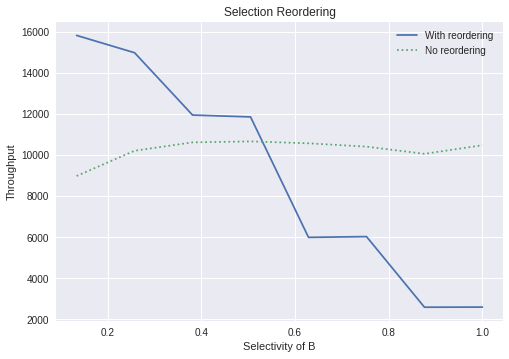

In [0]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(selectivity[1:], 47748 / np.array(thput_reorder)[1:], label='With reordering')
ax.plot(selectivity[1:], 47748 / np.array(thput_no_reorder)[1:], ':',label='No reordering')
ax.legend()
ax.set(xlabel='Selectivity of B', ylabel='Throughput',
       title='Selection Reordering')